In [13]:
import warnings
warnings.simplefilter("ignore")

In [14]:
from nideconv import simulate
import numpy as np
import pandas as pd

from nideconv.hierarchical_bayes import HierarchicalBayesianModel
from nideconv.group_analysis import GroupResponseFitter

import seaborn as sns

import matplotlib.pyplot as plt
import os

In [15]:
np.random.seed(12345)

In [16]:
conditions = [{'name':'Correct', 'mu_group':.25, 'std_group':.1, 'n_trials':16},
              {'name':'Error', 'mu_group':.5, 'std_group':.1, 'n_trials':(1,6)}]
data, onsets, pars = simulate.simulate_fmri_experiment(conditions,
                                                       n_subjects=9,
                                                       n_runs=3,
                                                       TR=1.5)

In [17]:
gmodel = GroupResponseFitter(data, onsets, input_sample_rate=1/1.5, concatenate_runs=False)
gmodel.add_event('Correct', basis_set='fourier', n_regressors=9, interval=[0, 21])
gmodel.add_event('Error', basis_set='fourier', n_regressors=9, interval=[0, 21])

In [18]:
gmodel.fit(type='ridge', alphas=[1.0])

In [19]:
from nideconv.utils import convolve_with_function

t = np.linspace(0, 21, 21*20)
hrf = np.zeros_like(t)
hrf[0] = 1
hrf = convolve_with_function(hrf, 'double_hrf', 20)

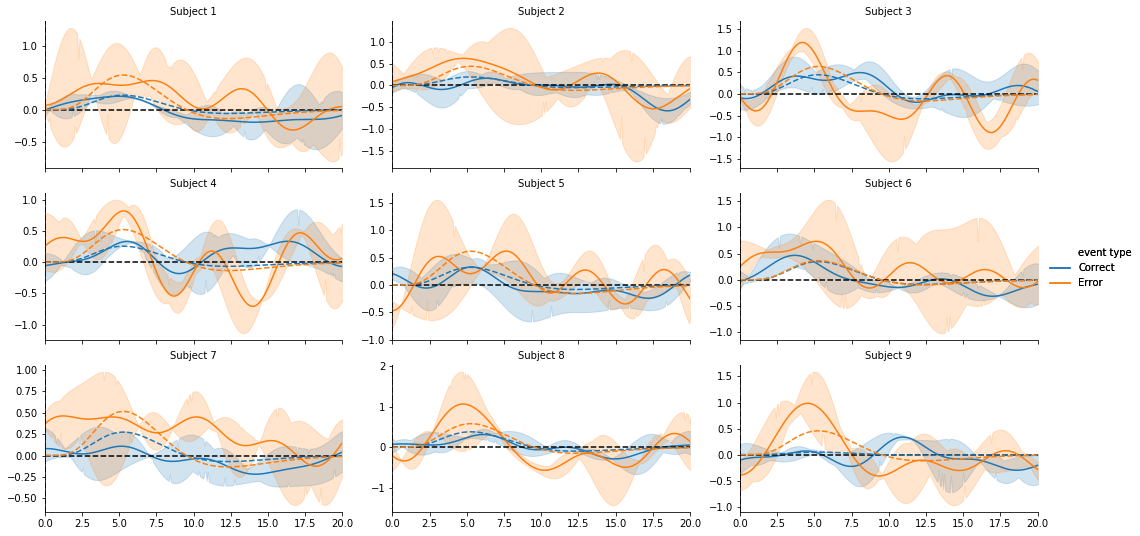

In [20]:
fac = gmodel.plot_subject_timecourses(ci=95, col_wrap=3)
fac[0].set(xlim=(0, 20))
fac[0].set_titles('Subject {col_name}')

for subject, ax in enumerate(fac[0].axes.ravel()):
    subject += 1
    ax.plot(t, hrf*pars.loc[subject, 'Correct'].amplitude, ls='--', lw=1.5, c=sns.color_palette()[0])
    ax.plot(t, hrf*pars.loc[subject, 'Error'].amplitude, ls='--', lw=1.5, c=sns.color_palette()[1])


plt.savefig(os.path.join(os.environ['HOME'], 'nideconv', 'frequentist_subjects.pdf'))


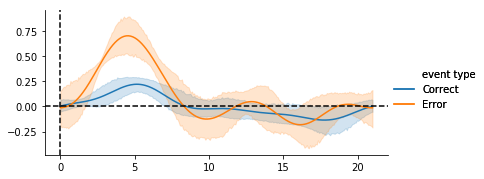

In [21]:
gmodel.plot_groupwise_timecourses(ci=95)

In [22]:
import nideconv

In [23]:
model = HierarchicalBayesianModel.from_groupresponsefitter(gmodel)
model.build_model()#recompile=True)

In [24]:
model.sample()

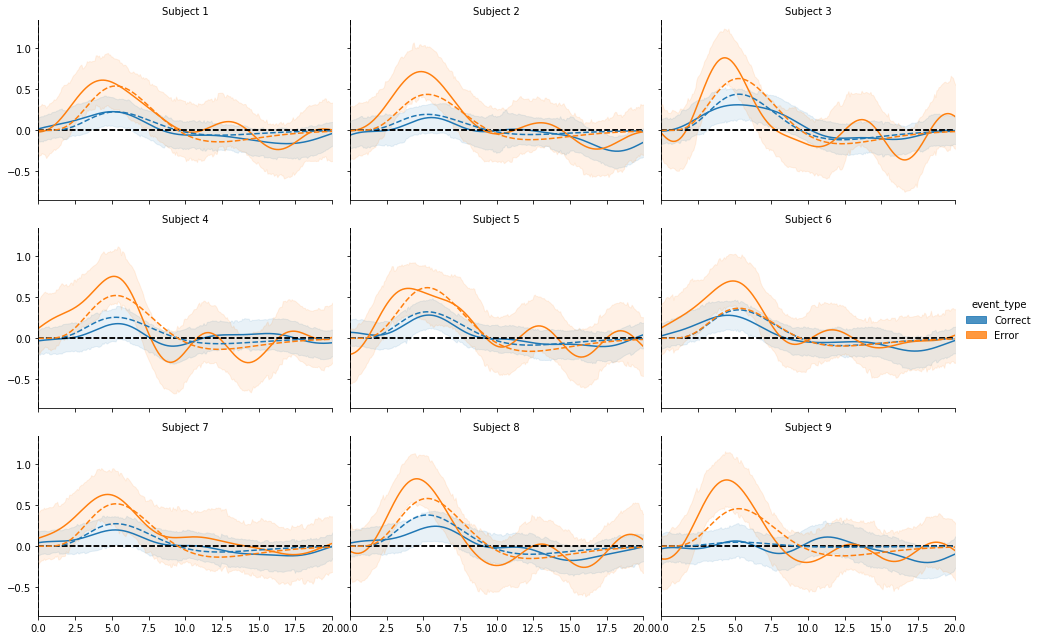

In [25]:
fac = model.plot_subject_timecourses(col_wrap=3)
fac.set(xlim=(0, 20))
fac.set_titles('Subject {col_name}')

for subject, ax in enumerate(fac.axes.ravel()):
    subject += 1
    ax.plot(t, hrf*pars.loc[subject, 'Correct'].amplitude, ls='--', lw=1.5, color=sns.color_palette()[0])
    ax.plot(t, hrf*pars.loc[subject, 'Error'].amplitude, ls='--', lw=1.5, color=sns.color_palette()[1])

plt.savefig(os.path.join(os.environ['HOME'], 'nideconv', 'bayesian_subject.pdf'))

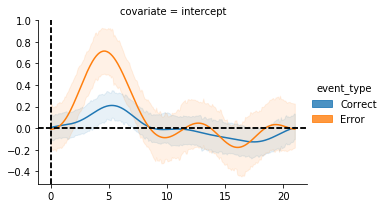

In [26]:
model.plot_group_timecourses()